In [9]:
import os
import requests
import math
import tiktoken
import torch
import torch.nn as nn
from torch.nn import functional as F
from transformer_language_model import TransformerLanguageModel

In [10]:
# Hyperparameters
batch_size = 1  # How many batches per training step
context_length = 4096 # Length of the token chunk each batch
dim_input = 128  # The size of our model token embeddings
num_blocks = 4  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention
learning_rate = 1e-3  # 0.001
dropout = 0.1  # Dropout rate
max_iters = 100 # Total of training iterations <- Change this to smaller number for testing
eval_interval = 50  # How often to evaluate
eval_iters = 20  # Number of iterations to average for evaluation
device = 'mps'  # Use Mac GPU if it's available.

infni=True
segment_len=64

TORCH_SEED = 1337

torch.set_default_device(device)

In [11]:
with open('data/sales_textbook.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [12]:
encoding = tiktoken.get_encoding("cl100k_base")
tokenized_text = encoding.encode(text)
max_token_value = max(tokenized_text) + 1  # the maximum value of the tokenized numbers
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long, device=device)  # put tokenized text into tensor

In [13]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.8)
split_val_text = int(len(tokenized_text) * 0.9)
print(split_val_text)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:split_val_text]
test_data = tokenized_text[split_val_text:]

70127


In [14]:
model = TransformerLanguageModel(dim_input=dim_input, num_heads=num_heads, num_blocks=num_blocks, context_length=context_length, max_token_value=max_token_value, dropout=dropout, infini=infni, segment_len=segment_len)
model = model.to(device)
print(model)

TransformerLanguageModel(
  (token_embedding_lookup_table): Embedding(100071, 128)
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (multi_head_attention_layer): InfiniMultiHeadAttention(
        (proj_k): Linear(in_features=128, out_features=128, bias=False)
        (proj_v): Linear(in_features=128, out_features=128, bias=False)
        (proj_q): Linear(in_features=128, out_features=128, bias=False)
        (proj_out): Linear(in_features=128, out_features=128, bias=False)
        (dropout_layer): Dropout(p=0.1, inplace=False)
      )
      (feed_forward_layer): FeedForward(
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=128, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (layer_norm_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True

In [15]:
# Get input embedding batch
def get_batch(split: str):
    data = train_data if split == 'train' else val_data
    idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
    x = torch.stack([data[idx:idx + context_length] for idx in idxs]).to(device)
    y = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs]).to(device)
    return x, y


# Calculate loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'valid']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x_batch, y_batch = get_batch(split)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


# Use AdamW optimizer
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate)
tracked_losses = list()
for step in range(max_iters):
    if step % eval_iters == 0 or step == max_iters - 1:
        losses = estimate_loss()
        tracked_losses.append(losses)
        print('Step:', step, 'Training Loss:', round(losses['train'].item(), 3), 'Validation Loss:',
              round(losses['valid'].item(), 3))

    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# Save the model state dictionary
torch.save(model.state_dict(), 'ckpt/model-infini-4096-64.pt')

Step: 0 Training Loss: 11.691 Validation Loss: 11.668
Step: 20 Training Loss: 8.865 Validation Loss: 8.944
Step: 40 Training Loss: 7.257 Validation Loss: 7.475
Step: 60 Training Loss: 6.371 Validation Loss: 6.697
Step: 80 Training Loss: 6.125 Validation Loss: 6.488
Step: 99 Training Loss: 6.186 Validation Loss: 6.43


In [16]:
# Generate
model.eval()
# start = ''
# start_ids = encoding.encode(start)
start_ids=test_data[:context_length]
x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
print(x.shape)
y = model.generate(x, max_new_tokens=int(10))
print('---------------')
print(encoding.decode(y[0].tolist()))
print('---------------')

/Users/jli943/miniforge3/envs/z2h/lib/python3.8/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


torch.Size([1, 4096])


---------------
 the customer's concerns. Here are some strategies for handling objections during the closing phase:
1. Actively listen: Give your undivided attention to the customer's objection and let them express their concerns fully. This shows respect and allows you to understand the underlying reasons behind their objection.
2. Empathize with the customer: Show understanding and acknowledge their concerns. By empathizing with their situation, you create a sense of trust and rapport, making it easier to find a resolution.
3. Clarify and rephrase: Repeat the objection in your own words to ensure you have understood it correctly. This demonstrates that you're actively listening and also gives the customer a chance to confirm or clarify their objection.
4. Provide relevant information: Offer specific details, facts, and evidence to address the objection. This could include sharing success stories, testimonials, or detailed product specifications. The goal is to alleviate any doubts o

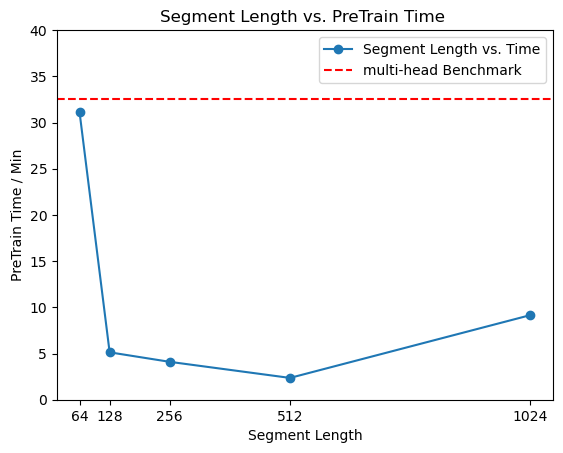

In [26]:
import matplotlib.pyplot as plt

x = [64, 128, 256, 512, 1024]
y = [31.1, 5.13, 4.1, 2.36, 9.16]

plt.plot(x, y, marker='o', label='Segment Length vs. Time')
plt.axhline(y=32.5, color='r', linestyle='--', label='multi-head Benchmark')
plt.xlabel('Segment Length')
plt.ylabel('PreTrain Time / Min')
plt.title('Segment Length vs. PreTrain Time ')
plt.xticks([64, 128, 256, 512, 1024], [64, 128, 256, 512, 1024])
plt.ylim(0, 40) 
plt.legend()
plt.show()